## Analyze A/B Test Results



### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [364]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [365]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [366]:
# number of entries
df.shape[0]

294478

c. The number of unique users in the dataset.

In [367]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [368]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [369]:
# Here I have checked both possibilities of the group being control group and receives new_page as
# landing_page and treatment group receives old_page as landing_page and summed them up.
new_control = df.query('landing_page == "new_page" and group == "control"').count()[0]
old_treat = df.query('landing_page == "old_page" and group == "treatment"').count()[0]
no_match = new_control + old_treat
no_match

3893

f. Do any of the rows have missing values?

In [370]:
df.info()
#no missing rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [371]:
# Dropping each combination that makes treatment group and newpage landingpage don't match
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [372]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [373]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [374]:
# search for duplication in user_id columns
unique_id = df2[df2.duplicated(['user_id'])]

c. What is the row information for the repeat **user_id**? 

In [375]:
unique_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [376]:
# I dropped the duplication and kept the first occurrence of it
df2.drop_duplicates(subset = 'user_id', keep = 'first', inplace = True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [377]:
# mean of all users
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [378]:
# I got the mean of the control group based on their conversion
ctrl_conv = df2.query('group == "control"')['converted'].mean()
ctrl_conv

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [379]:
# I got the mean of the treatment group based on their conversion
treat_conv = df2.query('group == "treatment"')['converted'].mean()
treat_conv

0.11880806551510564

d. What is the probability that an individual received the new page?

In [380]:
# I divided individuals who have received the new page as landing page by total users who received both old and new
df2.query('landing_page == "new_page"')['user_id'].nunique() / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

<span style ="color:darkblue">Based on the results above, I found that there is no evidence that the new page could lead to more conversions by comparing both probabilities control and experiment they are too similar to each other.</span>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<span style ="color:darkblue">**$$Null \to new\>page\>conversions\>are\>equals\>or\>worse\>than\>the\>old\>page$$**
**$$Alternative \to new\>page\>conversions\>are\>better\>than\>the\>old\>page$$**</span>

  **$$H_0:     p_{new} - p_{old} \leq 0$$
    $$H_1:     p_{new} - p_{old} > 0$$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [381]:
# Convert rate is equal to the overall convert rate under the null
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [382]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [383]:
# number of rows for new_page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [384]:
# number of rows for old_page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [385]:
# simulate under the null for n_new
new_page_converted = np.random.choice([0,1], size = n_new, p = [p_new, 1 - p_new])
new_page_converted.mean()

0.87822586195031316

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [386]:
# simulate under the null for n_old
old_page_converted = np.random.choice([0,1], size = n_old, p = [p_old, 1 - p_old])
old_page_converted.mean()

0.88070817902721754

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [387]:
# mean difference between two samples
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0024823170769043834

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [388]:
# sampling distribution of the difference in proportion

p_diffs = []

for _ in range(10000):
    new_converted = np.random.choice([0,1], size = n_new, p = [p_new, 1-p_new])
    old_converted = np.random.choice([0,1], size = n_old, p = [p_old, 1-p_old])
    p_diffs.append(new_converted.mean() - old_converted.mean())

In [389]:
# convert to array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

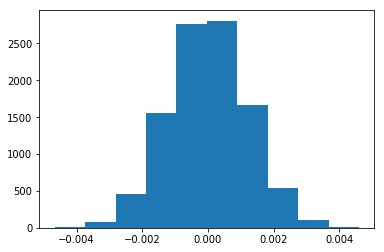

In [390]:
# plot the list of mean difference
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [391]:
# get control/treatment group
control = df2[df2['group'] == 'control']['converted'].mean()
treatment = df2[df2['group'] == 'treatment']['converted'].mean()

# get difference
obs_diff = treatment - control 
obs_diff

-0.0015782389853555567

In [392]:
# setting null value
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

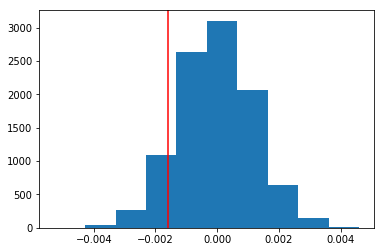

In [393]:
# plot null_vals and display obs_diff
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'red');

In [394]:
# proportion of the p_diffs are greater than the actual difference observed 
p_val = (p_diffs > obs_diff).mean()
p_val

0.90849999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<span style ="color:darkblue">In part j, I have calculated the proportion of the p_diffs which is greater than obs_diff (actual one). This value is called the p-value in scientific studies. This value means that we failed to reject the null hypothesis since the p-value is greater than type 1 error rate (0.05). To conclude, this means that there is no difference between the old and new pages.</span>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [395]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
n_old = df.query('group == "control"').count()[0]
n_new = df.query('group == "treatment"').count()[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 147202, 147276)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [396]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3350383297192379, 0.90906809911126674)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?

<span style ="color:darkblue">**p-value** = 0.90906809911126674</span>

<span style ="color:darkblue">**z-value** = 1.3350383297192379</span>

Do they agree with the findings in parts **j.** and **k.**?

<span style ="color:darkblue">Yes, they do.</span>

<span style ="color:darkblue">Since the p-value is similar to the one we computed previously, so we failed to reject the null hypothesis</span>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<span style ="color:darkblue">I would go with logisitc regression, since it is used to predict only two possible outcomes.</span>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [397]:
# add an intercept
df2['intercept'] = 1

# add dummies, I specified the landing page since it is the page that the treatment group receives
df2['ab_page'] = pd.get_dummies(df2['landing_page'])['new_page']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [398]:
# instantiate model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

# fit model
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [399]:
# displaying summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Nov 2019   Pseudo R-squ.:               8.077e-06
Time:                        04:34:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

<span style ="color:darkblue">**P-value** associated with ab_page = 0.190</span>
    
<span style ="color:darkblue">The null hypothesis in part II states that there is no difference between the old and new page, but in this part it is the complete opposite, the null hypothesis states that the old page is better than the new page and the alternative is that the new page is equal or better than the old page.</span>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

<span style ="color:darkblue">I would consider the timestamp variable, to see if the conversion influenced by a certain time of the day (morning, afternoon, evening) since some have school, work, etc.. and may not have the time to browse enough in a certain time like morning. But as every pro has a con, it may introduce us to complex model and have to deal with higher terms order.</span>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

In [400]:
# reading csv
countries_df = pd.read_csv('countries.csv')

# merging both dfs on the user id 
df3 = df2.merge(countries_df, on = 'user_id')

# To know the countries
df3.groupby(['country'])['user_id'].count()

country
CA     14499
UK     72466
US    203619
Name: user_id, dtype: int64

In [401]:
# dummy variables
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

# dropping the baseline (CA)
df3.drop('CA', axis = 1, inplace = True)

In [402]:
# add an intercept
df3['intercept'] = 1

# instantiate model
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'ab_page','UK', 'US']])

# fitting model
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [403]:
# displaying results
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Nov 2019   Pseudo R-squ.:               2.323e-05
Time:                        04:34:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

Does it appear that country had an impact on conversion? 

<span style ="color:darkblue">Based on the p-value above, it appears that they don't have an impact on conversion.</span>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [404]:
# multiplying each variable of the country by the new_page variable
df3['page_UK'] = df3['ab_page'] * df3['UK']
df3['page_US'] = df3['ab_page'] * df3['US']

# add an intercept
df3['intercept'] = 1

# instantiate model
logit_mod = sm.Logit(df3['converted'], df3[['intercept', 'page_UK', 'page_US']])

# fitting model
result = logit_mod.fit()

# displaying summary
result.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Nov 2019   Pseudo R-squ.:               1.082e-05
Time:                        04:34:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9926      0.008   -252.910      0.000      -2.008      -1.977
page_UK        0.0112      0.018      0.626      0.532      -0.024       0.046
page_US       -0.0144      0.012     -1.155      0.248      -0.039       0.010
==============================================================================
"""

<span style ="color:darkblue">The interaction between page and country doesn't appear to be significant effects on conversion since p-value > **0.05**</span>

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [405]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0